# Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_DIR = "/Users/elbethelzewdie/Downloads/ethiopia-fi-forecast/ethiopia-fi-forecast/data/raw"

data_path = f"{DATA_DIR}/ethiopia_fi_unified_data.csv"
impact_links_path = f"{DATA_DIR}/impact_sheet.csv"
reference_codes_path = f"{DATA_DIR}/reference_codes.csv"


In [3]:
data = pd.read_csv(data_path)

### 1. Dataset Overview

#### 1.1 Summarize by record_type, pillar, source_type

In [4]:
# Record type distribution
record_type_summary = data["record_type"].value_counts()
record_type_summary

record_type
observation    30
event          10
target          3
Name: count, dtype: int64

In [5]:
# Pillar distribution
pillar_summary = data["pillar"].value_counts(dropna=False)
pillar_summary


pillar
ACCESS           16
USAGE            11
NaN              10
GENDER            5
AFFORDABILITY     1
Name: count, dtype: int64

In [6]:
# Source type distribution
source_type_summary = data["source_type"].value_counts(dropna=False)
source_type_summary


source_type
operator      15
survey        10
regulator      7
research       4
policy         3
calculated     2
news           2
Name: count, dtype: int64

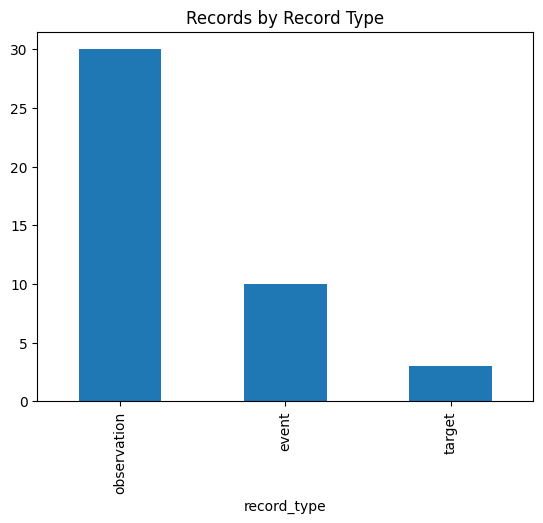

In [7]:
record_type_summary.plot(kind="bar", title="Records by Record Type")
plt.show()

### 2. Temporal Coverage Analysis

#### 2.1 Extract year safely

In [8]:
data["year"] = pd.to_datetime(
    data["observation_date"], errors="coerce"
).dt.year

# fallback to period_end if observation_date is missing
mask = data["year"].isna()
data.loc[mask, "year"] = pd.to_datetime(
    data.loc[mask, "period_end"], errors="coerce"
).dt.year

In [9]:
data["year"].describe()

count      43.000000
mean     2023.604651
std         2.574042
min      2014.000000
25%      2023.000000
50%      2024.000000
75%      2025.000000
max      2030.000000
Name: year, dtype: float64

#### 2.2 Coverage: which indicators have data in which years

In [10]:
coverage = (
    data[data["record_type"] == "observation"]
    .dropna(subset=["indicator_code", "year"])
    .groupby(["indicator_code", "year"])
    .size()
    .unstack(fill_value=0)
)


In [11]:
coverage.shape
coverage.head()

year,2014,2017,2021,2023,2024,2025
indicator_code,,,,,,
ACC_4G_COV,0,0,0,1,0,1
ACC_FAYDA,0,0,0,0,1,2
ACC_MM_ACCOUNT,0,0,1,0,1,0
ACC_MOBILE_PEN,0,0,0,0,0,1
ACC_OWNERSHIP,1,1,3,0,1,0


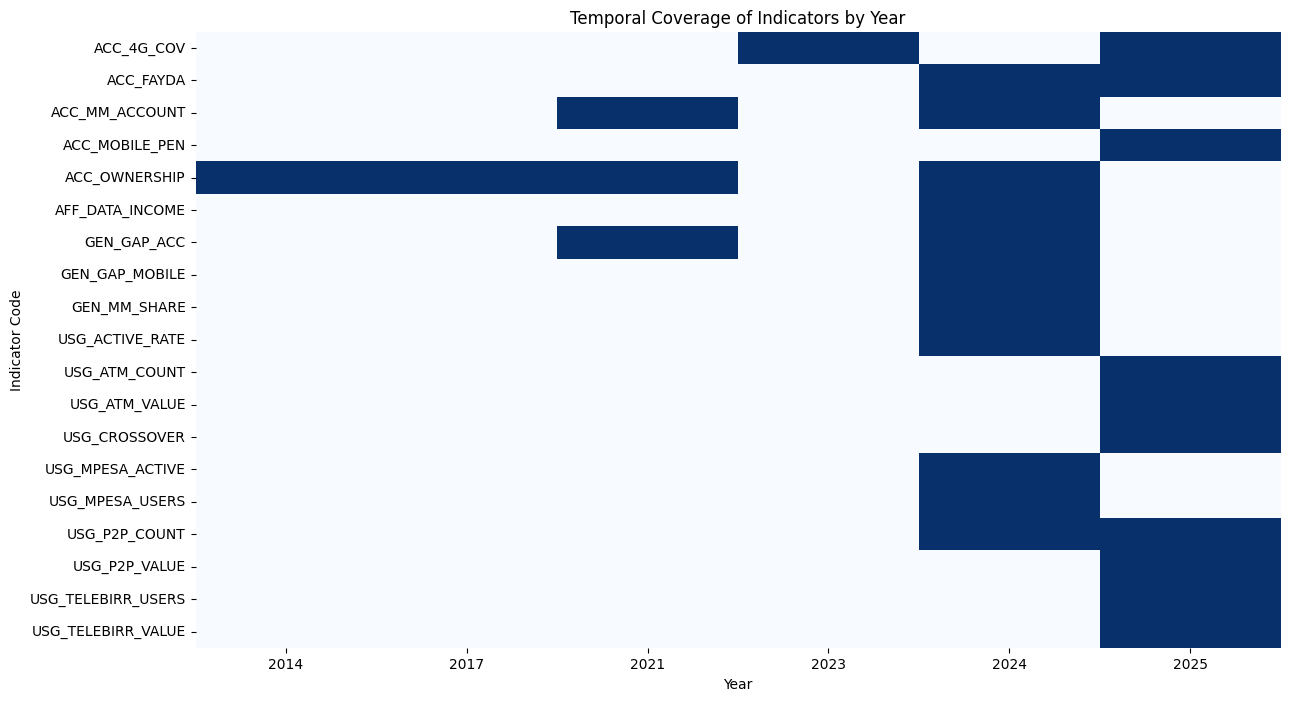

In [12]:
plt.figure(figsize=(14, 8))
sns.heatmap(
    coverage.astype(bool),
    cmap="Blues",
    cbar=False
)
plt.title("Temporal Coverage of Indicators by Year")
plt.xlabel("Year")
plt.ylabel("Indicator Code")
plt.show()

### 3. Data Quality Assessment

#### 3.1 Confidence distribution

In [13]:
data["confidence"].value_counts(dropna=False)

confidence
high      40
medium     3
Name: count, dtype: int64

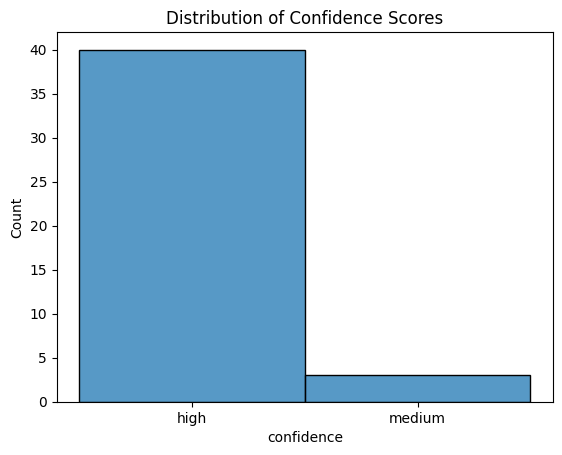

In [14]:
sns.histplot(data["confidence"].dropna(), bins=10)
plt.title("Distribution of Confidence Scores")
plt.show()


### 4. Identify Sparse Indicators

In [15]:
indicator_counts = (
    data[data["record_type"] == "observation"]
    .dropna(subset=["indicator_code", "year"])
    .groupby("indicator_code")["year"]
    .nunique()
    .sort_values()
)

In [16]:
sparse_indicators = indicator_counts[indicator_counts < 3]
sparse_indicators


indicator_code
USG_ACTIVE_RATE       1
USG_P2P_VALUE         1
USG_MPESA_USERS       1
USG_MPESA_ACTIVE      1
USG_CROSSOVER         1
USG_ATM_VALUE         1
USG_ATM_COUNT         1
USG_TELEBIRR_USERS    1
USG_TELEBIRR_VALUE    1
GEN_GAP_MOBILE        1
AFF_DATA_INCOME       1
ACC_MOBILE_PEN        1
GEN_MM_SHARE          1
GEN_GAP_ACC           2
ACC_MM_ACCOUNT        2
USG_P2P_COUNT         2
ACC_FAYDA             2
ACC_4G_COV            2
Name: year, dtype: int64

### 5. Account Ownership Trajectory (2011–2024)

#### 5.1 Filter account ownership indicator

In [17]:
account_ownership = data[
    (data["record_type"] == "observation")
    & (data["indicator_code"].str.contains("ACC_OWNERSHIP", na=False))
].sort_values("year")


#### 5.2 Plot trajectory

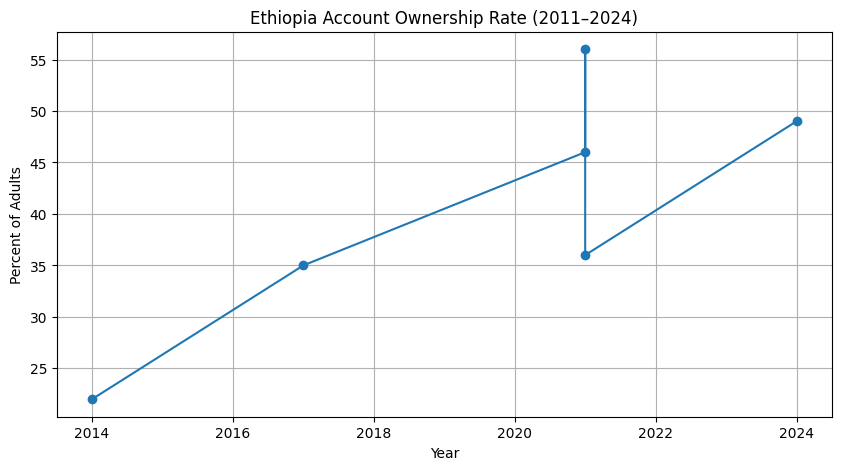

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(account_ownership["year"], account_ownership["value_numeric"], marker="o")
plt.title("Ethiopia Account Ownership Rate (2011–2024)")
plt.ylabel("Percent of Adults")
plt.xlabel("Year")
plt.grid(True)
plt.show()


### 6. Growth Rates Between Survey Years

In [19]:
account_ownership["growth_pp"] = account_ownership["value_numeric"].diff()

account_ownership[["year", "value_numeric", "growth_pp"]]

,year,value_numeric,growth_pp
0,2014,22.0,NaN
1,2017,35.0,13.0
2,2021,46.0,11.0
3,2021,56.0,10.0
4,2021,36.0,-20.0
5,2024,49.0,13.0


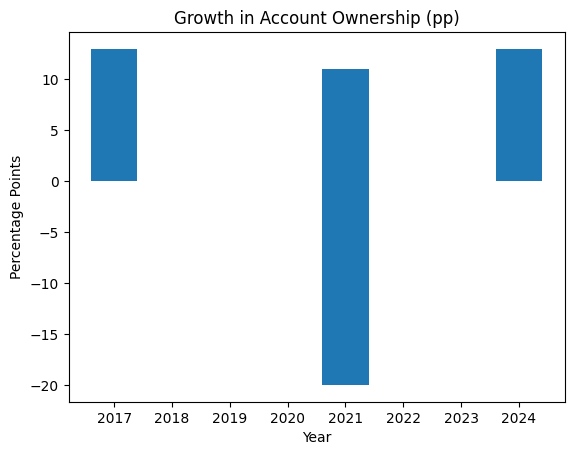

In [20]:
plt.bar(account_ownership["year"], account_ownership["growth_pp"])
plt.title("Growth in Account Ownership (pp)")
plt.ylabel("Percentage Points")
plt.xlabel("Year")
plt.show()


### 7. Disaggregated Analysis (If Available)

#### 7.1 Gender gap

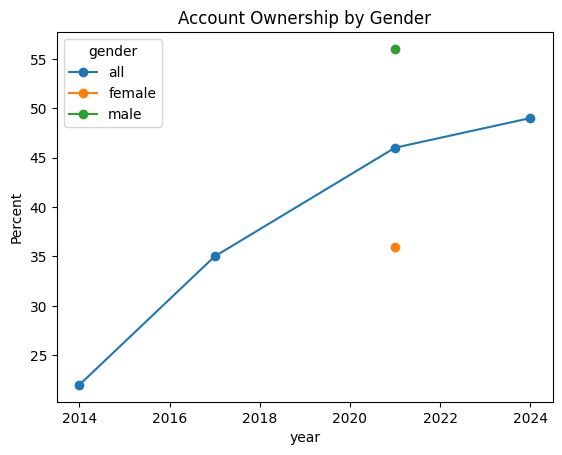

In [21]:
gender_data = account_ownership.dropna(subset=["gender"])

gender_pivot = gender_data.pivot(
    index="year", columns="gender", values="value_numeric"
)

gender_pivot.plot(marker="o")
plt.title("Account Ownership by Gender")
plt.ylabel("Percent")
plt.show()


In [22]:
gender_pivot["gap_male_female"] = (
    gender_pivot.get("male", 0) - gender_pivot.get("female", 0)
)
gender_pivot["gap_male_female"]


year
2014     NaN
2017     NaN
2021    20.0
2024     NaN
Name: gap_male_female, dtype: float64

#### 7.2 Urban vs Rural

In [23]:
location_data = account_ownership.dropna(subset=["location"])

duplicates = location_data.duplicated(subset=["year", "location"], keep=False)
location_data[duplicates][["year", "location", "value_numeric"]]


,year,location,value_numeric
2,2021,national,46.0
3,2021,national,56.0
4,2021,national,36.0


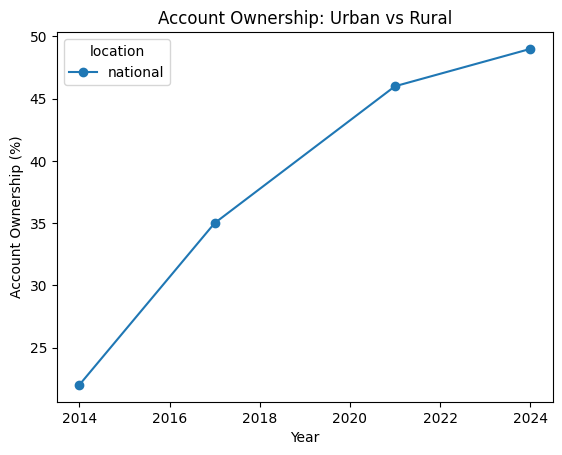

In [24]:

location_agg = location_data.groupby(["year", "location"])["value_numeric"].mean().reset_index()

location_pivot = location_agg.pivot(index="year", columns="location", values="value_numeric")


location_pivot.plot(marker="o")
plt.title("Account Ownership: Urban vs Rural")
plt.ylabel("Account Ownership (%)")
plt.xlabel("Year")
plt.show()


### 8. Investigate 2021–2024 Slowdown

In [25]:
account_ownership[
    account_ownership["year"].between(2021, 2024)
]


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,...,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,year,growth_pp
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,...,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,NaN,NaN,2021,11.0
3,REC_0004,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.0,NaN,percentage,...,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN,2021,10.0
4,REC_0005,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.0,NaN,percentage,...,NaN,NaN,NaN,Example_Trainee,2025-01-20,NaN,Gender disaggregated,NaN,2021,-20.0
5,REC_0006,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,49.0,NaN,percentage,...,NaN,NaN,NaN,Example_Trainee,2025-01-20,Account ownership increased from 46% to 49%,Survey Oct-Nov 2024,NaN,2024,13.0


### 9. Mobile Money Penetration Trend (2014–2024)

In [26]:
mobile_money = data[
    (data["indicator_code"] == "ACC_MM_ACCOUNT")
    & (data["record_type"] == "observation")  # observations, not "indicator"
].sort_values("year")


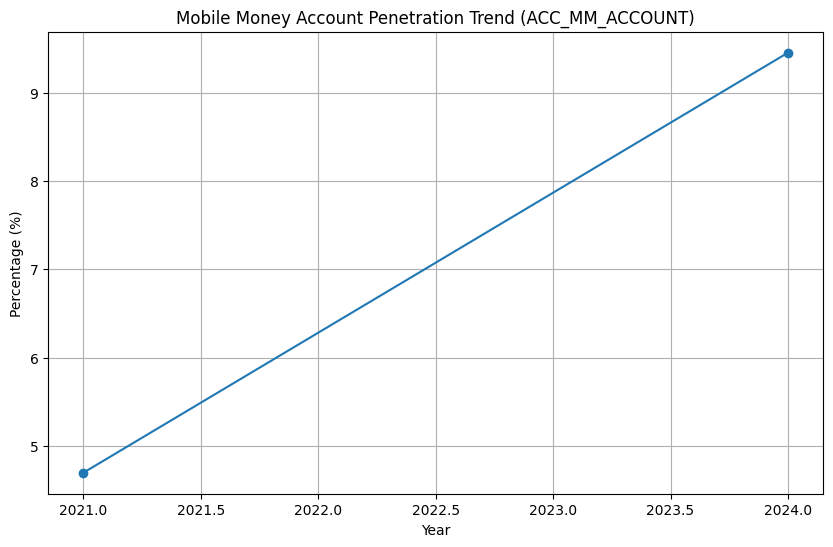

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(mobile_money["year"], mobile_money["value_numeric"], marker="o")
plt.title("Mobile Money Account Penetration Trend (ACC_MM_ACCOUNT)")
plt.xlabel("Year")
plt.ylabel("Percentage (%)")
plt.grid(True)
plt.show()

### 10. Digital Payment Adoption

In [28]:
digital_indicators = (
    data[["indicator", "indicator_code"]]
    .dropna()
    .drop_duplicates()
    .sort_values("indicator")
)

digital_indicators[
    digital_indicators["indicator"].str.contains(
        "mobile|money|payment|transaction|digital|telebirr|p2p",
        case=False,
        na=False
    )
]


,indicator,indicator_code
17,ATM Transaction Count,USG_ATM_COUNT
18,ATM Transaction Value,USG_ATM_VALUE
40,EthioPay Instant Payment System Launch,EVT_ETHIOPAY
11,Fayda Digital ID Enrollment,ACC_FAYDA
36,Fayda Digital ID Program Rollout,EVT_FAYDA
28,Female Mobile Money Account Share,GEN_MM_SHARE
6,Mobile Money Account Rate,ACC_MM_ACCOUNT
24,Mobile Money Activity Rate,USG_ACTIVE_RATE
29,Mobile Phone Gender Gap,GEN_GAP_MOBILE
10,Mobile Subscription Penetration,ACC_MOBILE_PEN


In [29]:
adoption_codes = [
    "USG_ACTIVE_RATE",
    "USG_P2P_COUNT",
    "USG_P2P_VALUE",
    "USG_TELEBIRR_VALUE",
    "USG_CROSSOVER"
]

adoption = data[
    (data["record_type"] == "observation") &
    (data["indicator_code"].isin(adoption_codes))
]

adoption_agg = (
    adoption
    .groupby(["indicator_code", "year"], as_index=False)
    .agg({"value_numeric": "mean"})
)


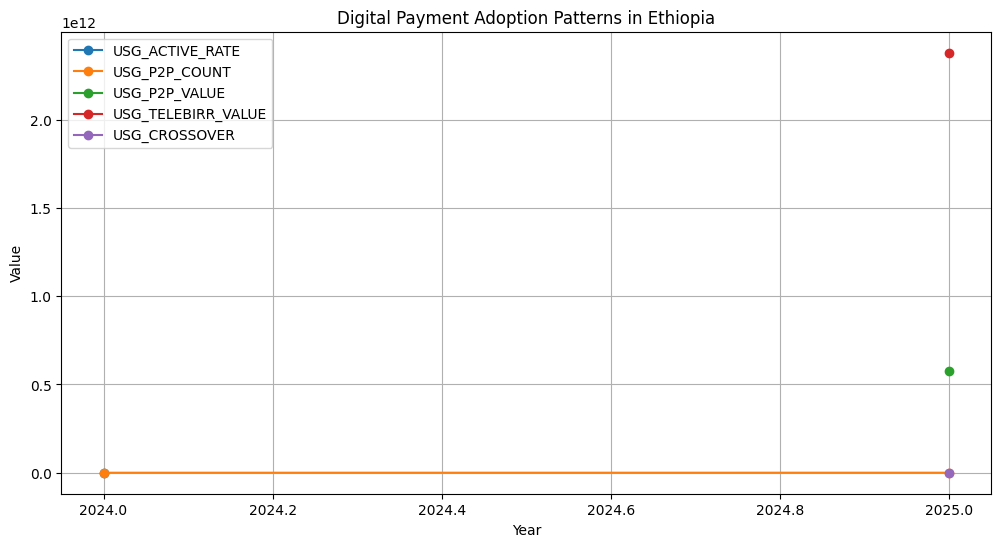

In [30]:
plt.figure(figsize=(12,6))

for code in adoption_codes:
    subset = adoption_agg[adoption_agg["indicator_code"] == code]
    plt.plot(subset["year"], subset["value_numeric"], marker="o", label=code)

plt.title("Digital Payment Adoption Patterns in Ethiopia")
plt.xlabel("Year")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


#### 10.1 Registered vs Active gap

In [31]:
gap_codes = ["ACC_MM_ACCOUNT", "USG_ACTIVE_RATE"]

gap = data[
    (data["record_type"] == "observation") &
    (data["indicator_code"].isin(gap_codes))
]

gap_agg = (
    gap.groupby(["indicator_code", "year"], as_index=False)
       .agg({"value_numeric": "mean"})
)


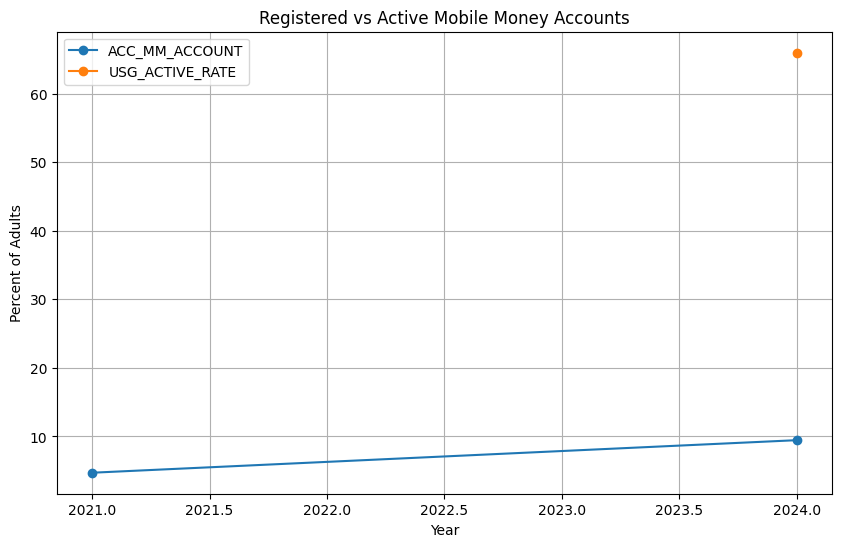

In [32]:
plt.figure(figsize=(10,6))

for code in gap_codes:
    subset = gap_agg[gap_agg["indicator_code"] == code]
    plt.plot(subset["year"], subset["value_numeric"], marker="o", label=code)

plt.title("Registered vs Active Mobile Money Accounts")
plt.xlabel("Year")
plt.ylabel("Percent of Adults")
plt.legend()
plt.grid(True)
plt.show()


#### 10.2 Payment use cases

In [33]:
p2p = adoption_agg[adoption_agg["indicator_code"].isin([
    "USG_P2P_COUNT",
    "USG_P2P_VALUE"
])]

p2p


,indicator_code,year,value_numeric
2,USG_P2P_COUNT,2024,4.970000e+07
3,USG_P2P_COUNT,2025,1.283000e+08
4,USG_P2P_VALUE,2025,5.777000e+11


### 12. Infrastructure Indicators

In [35]:
infra = data[
    data["indicator_code"].isin([
        "ACC_MOBILE_PEN",
        "ACC_4G_COV",
        "USG_ATM_COUNT",
        "USG_ATM_VALUE"
    ])
]


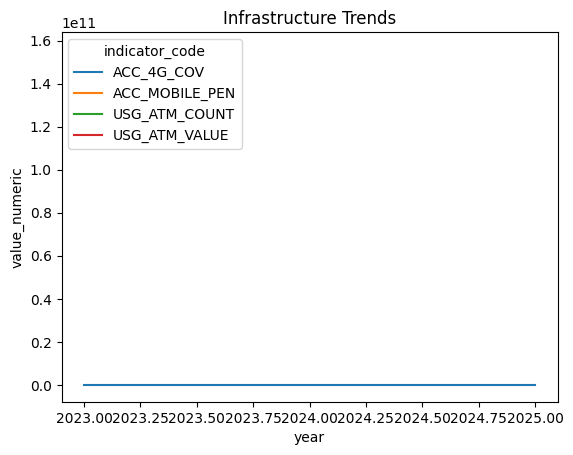

In [36]:
sns.lineplot(
    data=infra,
    x="year",
    y="value_numeric",
    hue="indicator_code"
)
plt.title("Infrastructure Trends")
plt.show()


### 13. Relationship with Inclusion Outcomes

In [37]:
merged = account_ownership.merge(
    infra, on="year", suffixes=("_access", "_infra")
)

merged[["value_numeric_access", "value_numeric_infra"]].corr()


,value_numeric_access,value_numeric_infra
value_numeric_access,NaN,NaN
value_numeric_infra,NaN,NaN


### 14. Event Timeline

In [38]:
events = data[data["record_type"].isin(["policy", "product_launch", "event"])]

events["event_year"] = pd.to_datetime(
    events["period_start"], errors="coerce"
).dt.year


/var/folders/7h/pt6smvdj6k993z68shptnrdc0000gn/T/ipykernel_2069/2839036964.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events["event_year"] = pd.to_datetime(


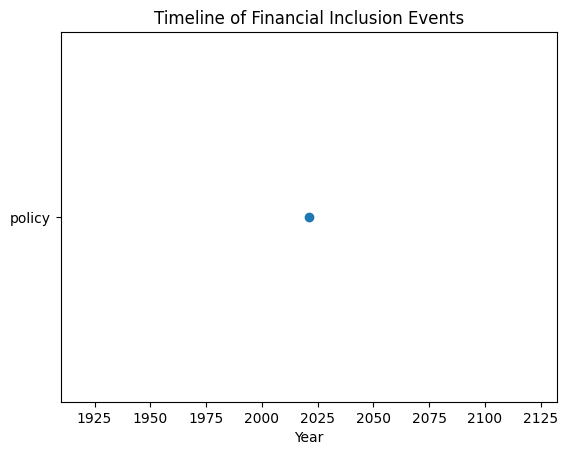

In [39]:
plt.scatter(events["event_year"], events["category"])
plt.title("Timeline of Financial Inclusion Events")
plt.xlabel("Year")
plt.show()


### 15. Overlay Events on Account Ownership

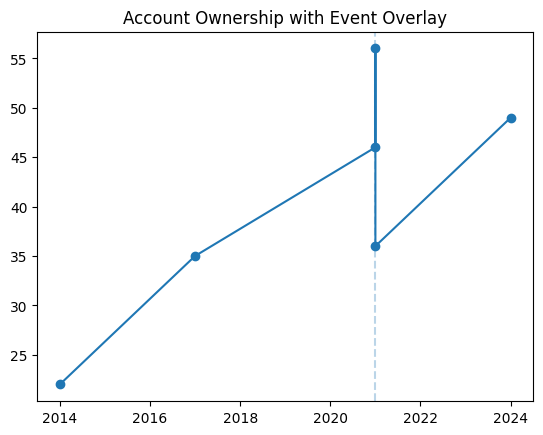

In [40]:
plt.plot(account_ownership["year"], account_ownership["value_numeric"], marker="o")

for _, row in events.iterrows():
    plt.axvline(row["event_year"], linestyle="--", alpha=0.3)

plt.title("Account Ownership with Event Overlay")
plt.show()


### 16. Indicator Correlation Matrix

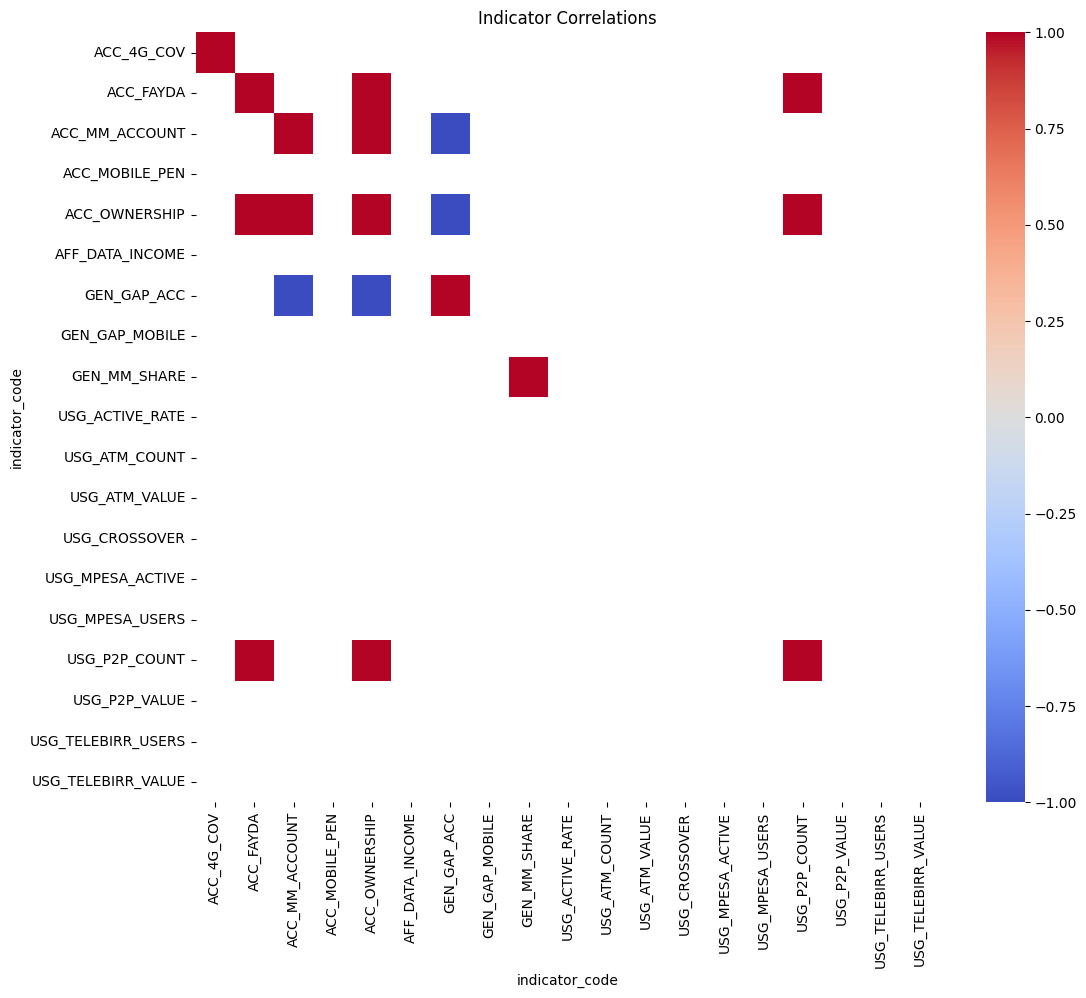

In [41]:
pivot = data.pivot_table(
    index="year",
    columns="indicator_code",
    values="value_numeric"
)

corr = pivot.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Indicator Correlations")
plt.show()
